
\begin{aligned}
\nabla_{\theta_{k}}\mathbb{E}_{S\left(x,t\right)\sim p_{\bm{\theta}}}L\left[Z_{\phi_{\infty}}\left(x,\omega;S\left(x,t\right)\right)\right]&=\nabla_{\theta_{k}}\int p_{\bm{\theta}}\left(x;S\left(x,t\right)\right)L\left[Z_{\phi_{\infty}}\left(x,\omega;S\left(x,t\right)\right)\right]\mathcal{D}S\\&=\int p_{\bm{\theta}}\left(x;S\left(x,t\right)\right)\nabla_{\theta_{k}}\ln p_{\bm{\theta}}\left(x;S\left(x,t\right)\right)L\left[Z_{\phi_{\infty}}\left(x,\omega;S\left(x,t\right)\right)\right]\mathcal{D}S\\&=\mathbb{E}_{S\left(x,t\right)\sim p_{\bm{\theta}}}\left\{ L\left[Z_{\phi_{\infty}}\left(x,\omega;S\left(x,t\right)\right)\right]\nabla_{\theta_{k}}\ln p_{\bm{\theta}}\left(x;S\left(x,t\right)\right)\right\} \\&\cong\mathbb{E}_{S\left(x,t\right)\sim p_{\bm{\theta}}}\left\{ L\left[Z_{\phi_{\infty}}\left(\left\{ x_{k}\right\} ,\omega;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right]\nabla_{\theta_{k}}\ln p_{\bm{\theta}}\left(\left\{ x_{k}\right\} ;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right\} \\&\approx\mathbb{E}_{S\left(x_{n},t\right)\sim\left(\Pi_{m=0}^{N-1}p_{\theta_{m}}\right),n=0\sim N-1}\left\{ L\left[Z_{\phi_{\infty}}\left(\left\{ x_{k}\right\} ,\omega;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right]\nabla_{\theta_{k}}\sum_{n=0}^{N-1}\ln p_{\theta_{n}}\left(x_{n};S\left(x_{n},t\right)\right)\right\} \\&=\mathbb{E}_{S\left(x_{k},t\right)\sim p_{\theta_{k}},k=0\sim N-1}\left\{ L\left[Z_{\phi_{\infty}}\left(\left\{ x_{k}\right\} ,\omega;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right]\nabla_{\theta_{k}}\ln p_{\theta_{k}}\left(x_{k};S\left(x_{k},t\right)\right)\right\} \\&=\mathbb{E}_{S\left(x_{k},t\right)\sim p_{\theta_{k}},k=0\sim N-1}\left\{ L\left[Z_{\phi_{\infty}}\left(\left\{ x_{k}\right\} ,\omega;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right]\frac{1}{\sqrt{2\pi}\sigma_{k}}\nabla_{\theta_{k}}e^{-\frac{\left(S_{k}-\theta_{k}\right)^{2}}{2\sigma_{k}^{2}}}\right\} \mathcal{D}S\\&=\frac{1}{\sqrt{2\pi}\sigma_{k}^{3}}\mathbb{E}_{S\left(x_{k},t\right)\sim p_{\theta_{k}},k=0\sim N-1}\left\{ L\left[Z_{\phi_{\infty}}\left(\left\{ x_{k}\right\} ,\omega;S\left(\left\{ x_{k}\right\} ,t\right)\right)\right]\left(S_{k}-\theta_{k}\right)e^{-\frac{\left(S_{k}-\theta_{k}\right)^{2}}{2\sigma_{k}^{2}}}\right\} \mathcal{D}S
\end{aligned}

In [3]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

def compute_acoustic_modes(phi_func, L=1.0, N=20000, rho0=1.0, rhos=1e3, K0=1.0, Ks=1e7, num_modes=10, omega2=5.0):
    """
    Solve the generalized eigenvalue problem for an acoustic system
    with varying material properties.

    Parameters
    ----------
    L : float
        Half-domain length [-L, L].
    N : int
        Number of grid points.
    b : float
        Location of the material interface.

    Returns
    -------
    x : ndarray
        Spatial grid.
    omega : ndarray
        Eigenfrequencies.
    full_modes : ndarray
        Normalized eigenmodes (size Nxnum_modes).
    """
    # Spatial grid
    x = np.linspace(-L, L, N)
    dx = x[1] - x[0]

    # Material properties
    phi = phi_func(x)
    K = K0 + (Ks - K0) * (1 + phi) * 0.5
    rho = rho0 + (rhos - rho0) * (1 + phi) * 0.5
    # Inverses
    inv_rho = 1.0 / rho
    inv_K = 1.0 / K

    # Harmonic average at interfaces
    inv_rho_half = 2 / (1/inv_rho[:-1] + 1/inv_rho[1:])  # size N-1

    # Left Dirichlet (p[0]=0), Right Neumann (p[N-1]=p[N-2])
    main_diag = -(inv_rho_half[1:] + inv_rho_half[:-1]) / dx**2  # size N-2
    upper_diag = inv_rho_half[1:-1] / dx**2                     # size N-3
    lower_diag = inv_rho_half[1:-1] / dx**2                     # size N-3
    main_diag[-1] = -inv_rho_half[-1] / dx**2  # Neumann at right boundary

    # Sparse matrices
    M = diags(
        diagonals=[main_diag, upper_diag, lower_diag],
        offsets=[0, 1, -1],
        format='csr'
    )
    S = diags(inv_K[1:-1], 0, format='csr')

    # Solve generalized eigenvalue problem: -M p = omega^2 S p
    eigvals, eigvecs = eigsh(
        -M, k=num_modes, M=S, sigma=omega2, which='LM'
    )

    # Eigenfrequencies
    omega = np.sqrt(np.abs(eigvals))

    # Sort eigenvalues and eigenvectors
    idx_sort = np.argsort(omega)
    omega = omega[idx_sort]
    modes_sorted = eigvecs[:, idx_sort]

    # Add boundary conditions to eigenmodes
    full_modes = np.zeros((N, num_modes))
    full_modes[1:-1, :] = modes_sorted
    full_modes[-1, :] = modes_sorted[-1, :]

    # Normalize eigenmodes
    for i in range(num_modes):
        full_modes[:, i] /= np.max(np.abs(full_modes[:, i]))

    return x, omega, full_modes


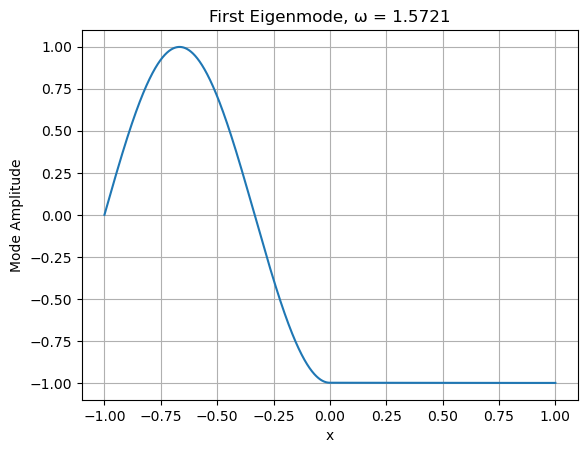

In [5]:
b = 0.
kappa = 0.0001
phi = lambda x: np.tanh((x-b) / kappa)

x, omega, modes = compute_acoustic_modes(
    phi_func=phi,
    L=1.0, N=20000,
    rho0=1.0, rhos=1e3, K0=1, Ks=1e7,
    num_modes=5, omega2=5.0
)

# Plot first mode
import matplotlib.pyplot as plt
plt.plot(x, modes[:, 1])
plt.title(f'First Eigenmode, ω = {omega[0]:.4f}')
plt.xlabel('x')
plt.ylabel('Mode Amplitude')
plt.grid(True)
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd

class PINN_CahnHilliard(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        return self.layers[-1](x)  # output φ

def gradients(y, x):
    return autograd.grad(y, x, grad_outputs=torch.ones_like(y), 
                         create_graph=True)[0]

def laplacian(y, x):
    grad_y = gradients(y, x)
    return gradients(grad_y, x).sum(dim=1, keepdim=True)

# Usage example
model = PINN_CahnHilliard([3, 64, 64, 64, 1])  # (x,y,t) -> φ
